In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pyspark.mllib.linalg import Vectors
from pyspark.sql import SparkSession

from scalable_gps.gp import GaussianProcess

In [2]:
def test_func(x):
    return 0.5*np.sin(x)*np.exp(-0.3*np.abs(x))

In [3]:
x_plot = np.linspace(-10, 10, 100)
y_plot = test_func(x_plot)

x_points = (np.random.random((15, 1)) - 0.5) * 20
y_points = test_func(x_points.squeeze())

In [4]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

22/10/28 11:32:03 WARN Utils: Your hostname, leonard-XPS-15-9500 resolves to a loopback address: 127.0.1.1; using 10.7.71.189 instead (on interface wlp0s20f3)
22/10/28 11:32:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/28 11:32:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
x_points_par = sc.parallelize(x_points).map(lambda x: Vectors.dense(x))
x_points_par.cache()
y_points_par = sc.parallelize(y_points)
y_points_par.cache()

ParallelCollectionRDD[2] at readRDDFromFile at PythonRDD.scala:274

In [21]:
gp = GaussianProcess(x=x_points_par, y=y_points_par, lengthscales=Vectors.dense(np.ones(1)), noise=0.2, signal_variance=1)
gp.optimize(
        lengthscale_constraints=(np.array(0.5), np.array(2)),
        noise_constraints=(0.01, 0.1),
        signal_variance_constraints=(0.1, 1.0),
        n_steps = 10,
    )

Minimum negative log likelihood of 0.217, noise is set to 0.0236 and signal variance to 0.236


In [22]:
plot_par = sc.parallelize(x_plot).map(lambda x: Vectors.dense(x))
plot_par.cache()

mean1, var1 = gp.predict_mean_var(plot_par)

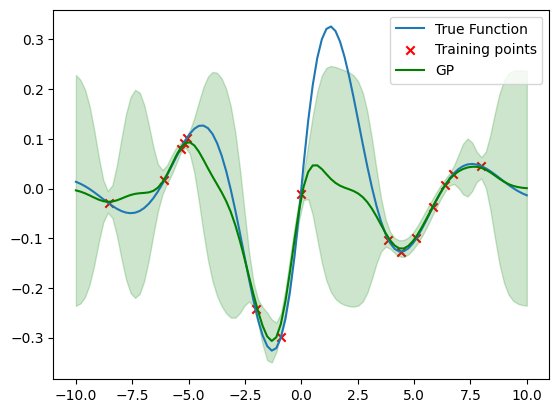

In [23]:
plt.plot(x_plot, y_plot, label="True Function")
plt.scatter(x_points, y_points, c="r",marker="x", label="Training points")
plt.plot(x_plot, mean1, c="g", label="GP")
plt.fill_between(x_plot, mean1-var1, mean1+var1, color="g", alpha=0.2)
plt.legend()

In [24]:
gp.noise=0.05

In [25]:
gp.negative_log_likelihood()

2.0118636815254156

In [11]:
mean1, var1 = gp.predict_mean_var(plot_par)

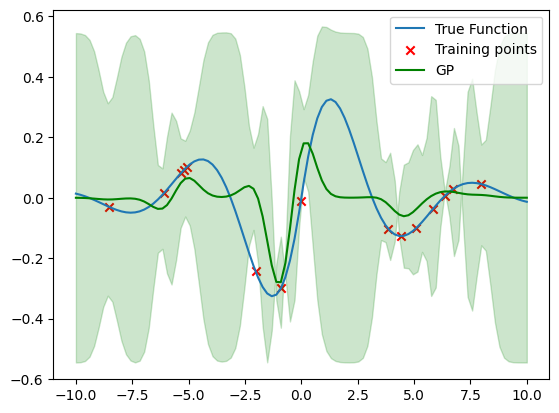

In [12]:
plt.plot(x_plot, y_plot, label="True Function")
plt.scatter(x_points, y_points, c="r",marker="x", label="Training points")
plt.plot(x_plot, mean1, c="g", label="GP")
plt.fill_between(x_plot, mean1-var1, mean1+var1, color="g", alpha=0.2)
plt.legend()

In [13]:
gp.signal_variance = 2.

In [14]:
mean1, var1 = gp.predict_mean_var(plot_par)

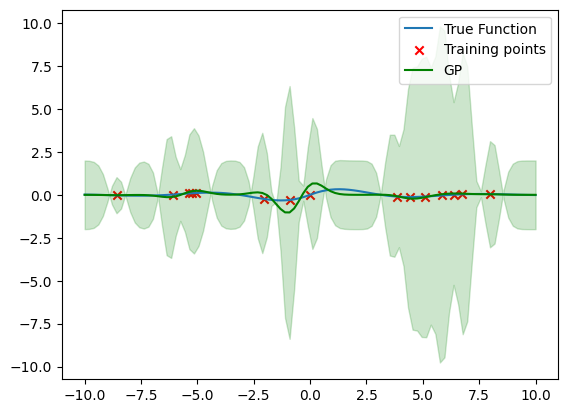

In [15]:
plt.plot(x_plot, y_plot, label="True Function")
plt.scatter(x_points, y_points, c="r",marker="x", label="Training points")
plt.plot(x_plot, mean1, c="g", label="GP")
plt.fill_between(x_plot, mean1-var1, mean1+var1, color="g", alpha=0.2)
plt.legend()